In [1]:
!git clone https://github.com/KORALLLL/diffusion.git
!pip install torcheval

Cloning into 'diffusion'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 280 (delta 153), reused 201 (delta 78), pack-reused 0 (from 0)
Receiving objects: 100% (280/280), 3.75 MiB | 16.12 MiB/s, done.
Resolving deltas: 100% (153/153), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [2]:
import pickle, gzip, math, os,sys, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc, random, timm, torchvision, io, PIL
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torchvision.transforms import transforms
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from fastcore.foundation import L, store_attr

from fastcore.test import test_close
import logging



sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/kaggle/working/diffusion'))


from diffusion.data_utils import *
from diffusion.learners import *
from diffusion.callbacks import *
from diffusion.metrics import *
from diffusion.utils import *
from diffusion.modules import *

In [3]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
 

# Loading Images

In [4]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


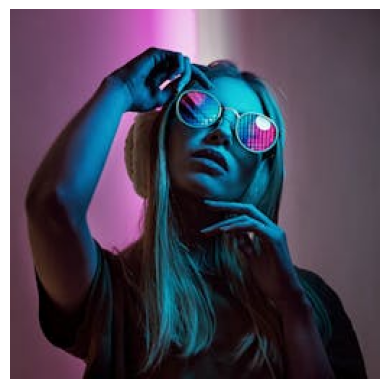

In [5]:
content_im = download_image(face_url).to('cuda:0')
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [6]:
content_im.min(), content_im.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

# optimizing Images

In [7]:
class LengthDataset:
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0
    
def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                      DataLoader(LengthDataset(1), batch_size=1))

In [8]:
for batch in get_dummy_dls(10).train:
    print(batch)

[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]


In [9]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

<Axes: >

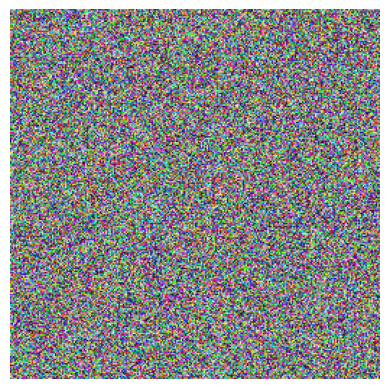

In [ ]:
model = TensorModel(torch.rand_like(content_im))
show_image(model())

In [ ]:
model.t.requires_grad

In [ ]:
[p.shape for p in model.parameters()]

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

In [14]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(),MultiGPUsCallback()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse,
               lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(5)

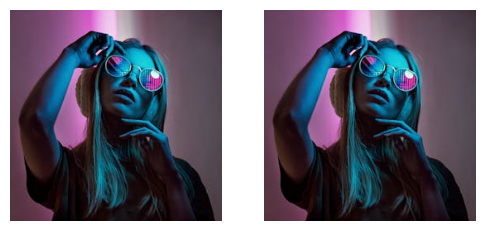

In [15]:
show_images([learn.model().clip(0,1), content_im])

# Viewing result

In [16]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): 
        store_attr()
        self.images=[]
        self.i=0
    def after_batch(self, learn):
        if self.i % self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0,1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

Using 2 GPUs for training


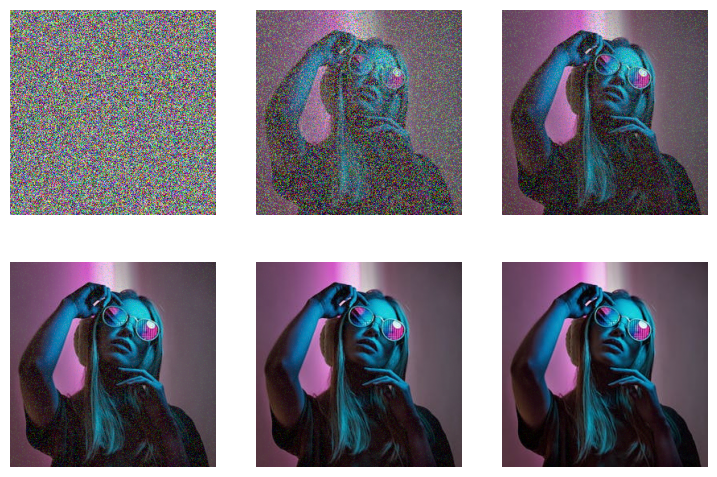

In [17]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse,
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

# Getting images from VGG16

In [18]:
print(1)

1


In [19]:
print(timm.list_models("*vgg*"))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [20]:
vgg16 = timm.create_model('vgg16', pretrained=True).to('cuda:0').features

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [21]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Normalizing images

In [22]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [23]:
(content_im - imagenet_mean) / imagenet_std

RuntimeError: The size of tensor a (256) must match the size of tensor b (3) at non-singleton dimension 2

In [24]:
imagenet_mean.shape

torch.Size([3])

In [25]:
content_im.shape

torch.Size([3, 256, 256])

In [26]:
imagenet_mean[:, None, None].shape

torch.Size([3, 1, 1])

In [27]:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:, None, None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:, None, None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [28]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [29]:
normalize(content_im).mean(dim=(1,2))

tensor([-0.9724, -0.9594, -0.4191], device='cuda:0')

In [30]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [31]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

# Get intermediate representation

In [32]:
def calc_features(imgs, target_layers=[18, 25]):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [33]:
feats = calc_features(content_im)
[f.shape for f in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

# Optimizin ad image with content loss

In [40]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=[18,25]):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im):
        return sum((f1-f2).pow(2).mean() for f1, f2 in
                  zip(calc_features(input_im, self.target_layers),
                     self.target_features
                     ))

Using 2 GPUs for training


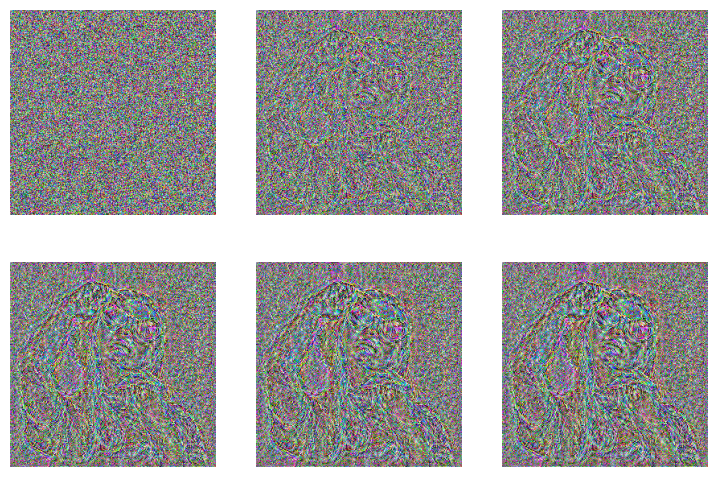

In [41]:
loss_function_perceptual = ContentLossToTarget(content_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual,
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

Using 2 GPUs for training


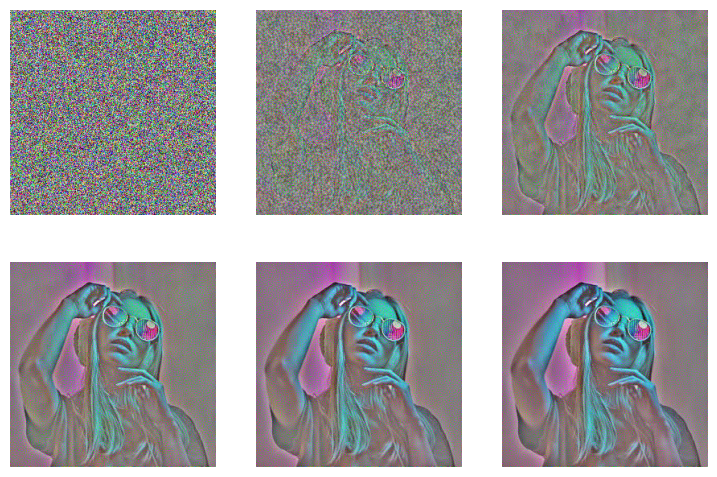

In [51]:
loss_function_percetual = ContentLossToTarget(content_im, target_layers=(1,6))
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_percetual,
               lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

# Style loss with Gram matrix

In [52]:
t = tensor([
    [0,1,0,1,1,0,0,1,1],
    [0,1,0,1,0,0,0,0,1],
    [1,0,1,1,1,1,1,1,0],
    [1,0,1,1,0,1,1,0,0]
])

In [53]:
torch.einsum('fs, gs -> fg', t,t)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

In [54]:
t.matmul(t.T)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

## trying it out

<Axes: >

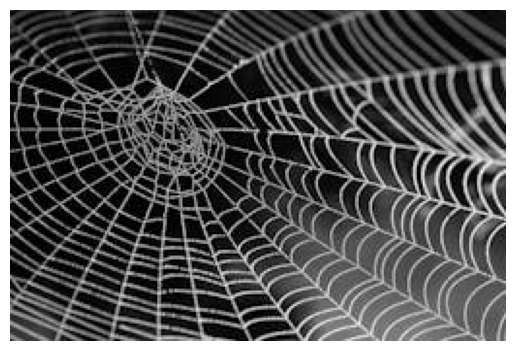

In [57]:
style_im = download_image(spiderweb_url).to('cuda:0')
show_image(style_im)

In [58]:
def calc_grams(img, target_layers=[1,6,11,18,25]):
    return L(torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
             for x in calc_features(img, target_layers))

In [59]:
style_grams = calc_grams(style_im)

In [62]:
[g.shape for g in style_grams]

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [63]:
style_grams.attrgot('shape')

(#5) [torch.Size([64, 64]),torch.Size([128, 128]),torch.Size([256, 256]),torch.Size([512, 512]),torch.Size([512, 512])]

In [64]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1,6,11,18,25)):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im):
        return sum((f1-f2).pow(2).mean() for f1, f2 in
                  zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [65]:
style_loss = StyleLossToTarget(style_im)

In [66]:
style_loss(content_im)

tensor(429.7879, device='cuda:0', grad_fn=<AddBackward0>)

# Style transfer

Using 2 GPUs for training


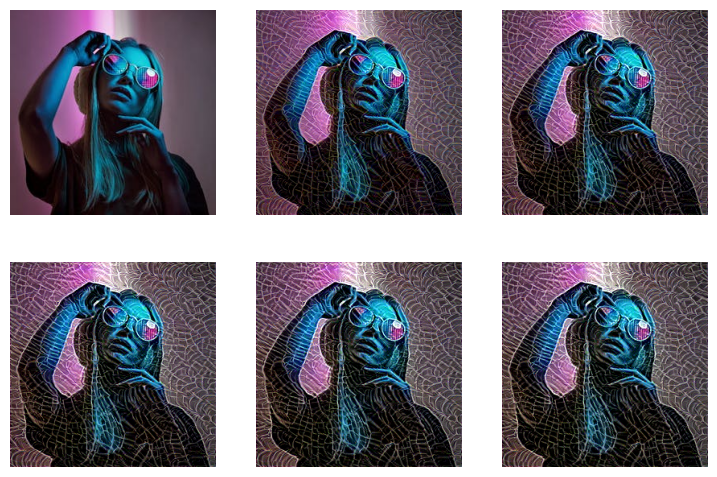

In [71]:
model = TensorModel(content_im)
style_los = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)

learn = Learner(model, get_dummy_dls(150), combined_loss, 
               lr=1e-2, cbs=cbs, opt_func=optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

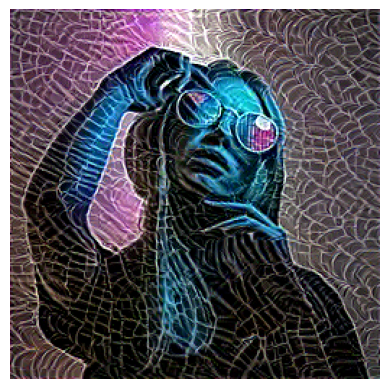

In [72]:
show_image(learn.model().clip(0,1));

Using 2 GPUs for training


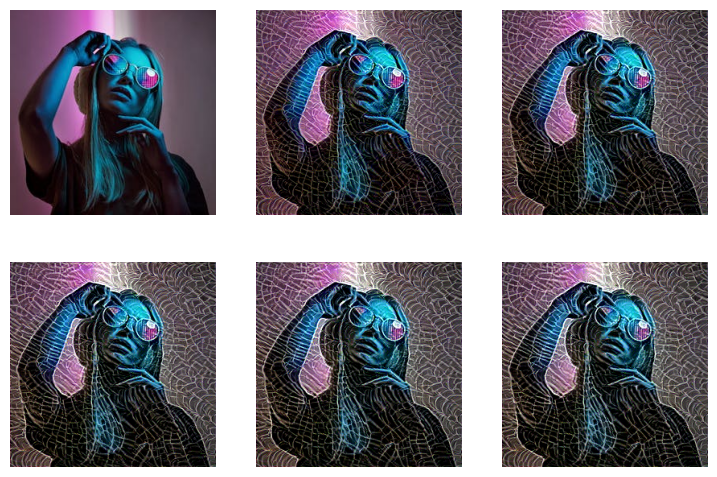

In [73]:
model = TensorModel(content_im)
style_los = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)

learn = Learner(model, get_dummy_dls(300), combined_loss, 
               lr=1e-2, cbs=cbs, opt_func=optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])